<a href="https://colab.research.google.com/github/anthonypenaflor/CS567_ML_Project/blob/llm-dfq/mlproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "backend:cudaMallocAsync"
# from transformers import AutoModelForCausalLM, AutoTokenizer
from vllm import LLM, SamplingParams

# import seaborn as sns
# import matplotlib.pyplot as plt
import pandas as pd

# import torch

# Load the Detect AI Generated Text
Let's have a look at all the data files

In [2]:
DATA_DIR = "/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/"

for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/sample_submission.csv
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/test_essays.csv
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/train_essays.csv
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/train_prompts.csv
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/train_v2_drcat_02.csv
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/train_essays_final_sample_preds.txt
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/train_essays_final_sample_preds-mistral-IT.txt
/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/train_essays_final_sample_preds-mistral-IT-ICL-1-shot.txt


# Explore the dataset

Let's look at the distribution of labels in the training set.

In [3]:
df_train_prompts = pd.read_csv(DATA_DIR + "train_prompts.csv")
print(df_train_prompts.info())
df_train_prompts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   prompt_id     2 non-null      int64 
 1   prompt_name   2 non-null      object
 2   instructions  2 non-null      object
 3   source_text   2 non-null      object
dtypes: int64(1), object(3)
memory usage: 192.0+ bytes
None


,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


**Only two prompts are used in this dataset.**

Let's look at the distribution of text/generated in the training set.

In [4]:
df_train_essays = pd.read_csv(DATA_DIR + "train_essays.csv")
print(df_train_essays.info())
df_train_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB
None


,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [16]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays, x="prompt_id")

abs_values = df_train_essays["prompt_id"].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

NameError: name 'plt' is not defined

In [17]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays, x="generated")

abs_values = df_train_essays["generated"].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

NameError: name 'plt' is not defined

**1375 essays are written by human and only 3 by AI.**

**The distribution between the two prompts is pretty equal.**

In [31]:
df_test_essays = pd.read_csv(DATA_DIR + "test_essays.csv")
print(df_test_essays.info())
df_test_essays.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         3 non-null      object
 1   prompt_id  3 non-null      int64 
 2   text       3 non-null      object
dtypes: int64(1), object(2)
memory usage: 200.0+ bytes
None


,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [32]:
df_test_essays["text"].apply(lambda x: len(x))

0    12
1    12
2    12
Name: text, dtype: int64

**The test dataset contains only 3 essays. The length of each essay is very small (12 characters).**

# Add new data to the training dataset

As the dataset does not contain any generated data. We will use the dataset created by [DAREK KŁECZEK](https://www.kaggle.com/competitions/llm-detect-ai-generated-text/discussion/455517)

In [5]:
df_train_essays_ext = pd.read_csv(DATA_DIR + "train_v2_drcat_02.csv", encoding="utf-8")

df_train_essays_ext.rename(columns={"label": "generated"}, inplace=True)

df_train_essays_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44868 entries, 0 to 44867
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           44868 non-null  object
 1   generated      44868 non-null  int64 
 2   prompt_name    44868 non-null  object
 3   source         44868 non-null  object
 4   RDizzl3_seven  44868 non-null  bool  
dtypes: bool(1), int64(1), object(3)
memory usage: 1.4+ MB


In [6]:
df_train_essays_ext.head()

,text,generated,prompt_name,source,RDizzl3_seven
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False


Text(0.5, 1.0, 'Distribution of Generated Text')

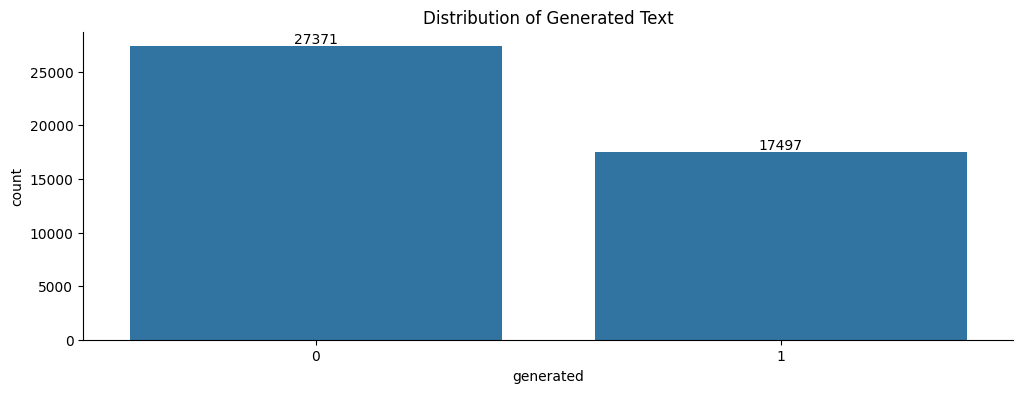

In [35]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_ext, x="generated")

abs_values = df_train_essays_ext["generated"].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [5]:
df_train_essays

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [7]:
df_train_essays_final = pd.concat(
    [df_train_essays_ext[["text", "generated"]], df_train_essays[["text", "generated"]]]
)

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46246 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       46246 non-null  object
 1   generated  46246 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


# Prepare data

Let's count the number of words in each essay

In [8]:
df_train_essays_final["text_length"] = df_train_essays_final["text"].apply(lambda x: len(x.split()))

Text(0.5, 0.98, 'Distribution of the length per essay - Train dataset')

<Figure size 4000x5000 with 0 Axes>

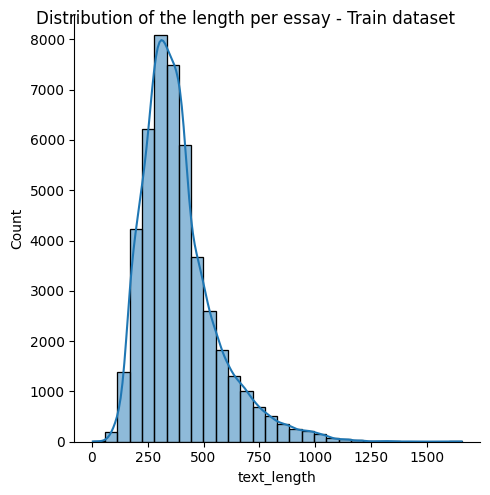

In [39]:
fig = plt.figure(figsize=(40, 50))
plot = sns.displot(data=df_train_essays_final,
                   x="text_length", bins=30, kde=True)
plot.fig.suptitle("Distribution of the length per essay - Train dataset")

In [40]:
df_train_essays_final["text_length"].mean() + df_train_essays_final["text_length"].std()

556.1289768295229

In [9]:
# Create prompt templates for the model
ptemplate_nosamples = "Here is an essay that could have been written by a human or a language model. Your task is to identify whether the third essay was written by a human (label 0) or language model (label 1). Answer either 0 or 1 only."


ptemplate_wsamples = """You will be provided with 2 essays, one written by a human (label 0) and another written by a language model (label 1). 
Essay 1: <ESSAY1>
Label: <LABEL1>
Essay 2: <ESSAY2>
Label: <LABEL2>

You are an expert detector and your task is to identify whether the next essay was written by a human (label 0) or language model (label 1). 
Answer 0 or 1 only.
Essay 3: <ESSAY3>
Label:"""

In [10]:
df_train_essays_final["text"]

0       Phones\n\nModern humans today are always on th...
1       This essay will explain if drivers should or s...
2       Driving while the use of cellular devices\n\nT...
3       Phones & Driving\n\nDrivers should not be able...
4       Cell Phone Operation While Driving\n\nThe abil...
                              ...                        
1373    There has been a fuss about the Elector Colleg...
1374    Limiting car usage has many advantages. Such a...
1375    There's a new trend that has been developing f...
1376    As we all know cars are a big part of our soci...
1377    Cars have been around since the 1800's and hav...
Name: text, Length: 46246, dtype: object

In [11]:
seed = 42
n_samples = 10000
n_icl_samples = 2

df_train_essays_final_generated = df_train_essays_final[df_train_essays_final["generated"] == 1]
df_train_essays_final_human = df_train_essays_final[df_train_essays_final["generated"] == 0]

df_train_essays_final_generated_sample = df_train_essays_final_generated.sample(
    n=n_samples + n_icl_samples, random_state=seed
)
df_train_essays_final_human_sample = df_train_essays_final_human.sample(
    n=n_samples + n_icl_samples, random_state=seed
)

df_train_essays_final_sample = pd.concat(
    [
        df_train_essays_final_generated_sample.iloc[:n_samples, :],
        df_train_essays_final_human_sample.iloc[:n_samples, :],
    ]
)

df_train_essays_icl_examples = pd.concat(
    [
        df_train_essays_final_generated_sample.iloc[n_samples:, :],
        df_train_essays_final_human_sample.iloc[n_samples:, :],
    ]
)

len(df_train_essays_final_sample), len(df_train_essays_icl_examples)

(20000, 4)

In [12]:
df_train_essays_final_sample

,text,generated,text_length
27407,"Hey, ya'll! 😃\n\nSo, like, technology is prett...",1,250
33551,"In my opinion, students should commit to a ca...",1,229
30926,Meditation and mindfulness practices have beco...,1,495
36050,"As an eighth-grade student, I believe it is cr...",1,417
28710,"As an 8th grader, I find it fascinating to exp...",1,370
...,...,...,...
16900,Driverless cars are something that will very s...,0,519
9819,Technology to read students' emotional express...,0,406
11923,i think technology that reads facial expressio...,0,171
17283,"Driverless cars are coming, are they safe for ...",0,443


In [13]:
df_train_essays_icl_examples[df_train_essays_icl_examples["generated"] == 1]

,text,generated,text_length
29377,"As an 8th-grade student, I have always been cu...",1,409
35490,"Hey, I'm just an average 8th grader, so bear w...",1,311


In [14]:
gen_essay_sample = df_train_essays_icl_examples[
    df_train_essays_icl_examples["generated"] == 1
].iloc[0]["text"]
human_essay_sample = df_train_essays_icl_examples[
    df_train_essays_icl_examples["generated"] == 0
].iloc[0]["text"]

prompts_wsamples = [
    ptemplate_wsamples.replace("<ESSAY1>", human_essay_sample)
    .replace("<LABEL1>", "0")
    .replace("<ESSAY2>", gen_essay_sample)
    .replace("<LABEL2>", "1")
    .replace("<ESSAY3>", essay)
    for essay in df_train_essays_final_sample["text"]
]

len(prompts_wsamples)

20000

In [15]:
prompts_wsamples[1]

"You will be provided with 2 essays, one written by a human (label 0) and another written by a language model (label 1). \nEssay 1: Although, participating in a extracurricular activity like sports,yearbook, and student council, it may not be the best for everyone. Some kids prefer not to play for a basketball,soccer, or volleyball team, It's not one of their comfort zones or something that they enjoy. Everyone has thier personal opinios,and people shold be recpect that. You can't force someone to do something if they don't want to do it, they would not be enjoying their time. Kids should be doing something fun,something they can enjoy, and something they can look back on as a good memory. Thats a big part of being a part of a club or team. Therefore, I disagree with the decison that all students must participate in at least one extracurricular activity.\n\nAsthma, Asthma is a shortness of breathe or someone having trouble breathing. People with\n\nAsthma may not be capable or comforta

In [16]:
len(prompts_wsamples)

20000

# Create the model

In [17]:
# model_name = "mistralai/Mistral-7B-v0.1"  # "meta-llama/Llama-2-13b-hf"
model_config = {
    "model": "mistralai/Mistral-7B-Instruct-v0.2",
    "gpu_memory_utilization": 0.9,
}

In [53]:
# del llm
# del outputs

NameError: name 'llm' is not defined

In [18]:
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
# tokenizer = AutoTokenizer.from_pretrained(model_name)

llm = LLM(**model_config)
params = SamplingParams(temperature=0.0, logprobs=100)

INFO 04-27 18:47:19 llm_engine.py:87] Initializing an LLM engine with config: model='mistralai/Mistral-7B-Instruct-v0.2', tokenizer='mistralai/Mistral-7B-Instruct-v0.2', tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, seed=0)
INFO 04-27 18:47:26 weight_utils.py:163] Using model weights format ['*.safetensors']
INFO 04-27 18:47:35 llm_engine.py:357] # GPU blocks: 12650, # CPU blocks: 2048
INFO 04-27 18:47:36 model_runner.py:684] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 04-27 18:47:36 model_runner.py:688] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are runnin

In [19]:
outputs = llm.generate(prompts_wsamples, params)

Processed prompts:   0%|                                                                                                                                                                                 | 0/20000 [00:00<?, ?it/s]

In [ ]:
preds = [o.outputs[0].text for o in outputs]
len(preds)

20000

In [ ]:
import numpy as np

In [5]:
DATA_DIR  # '/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/'

'/home/dafirebanks/projects/CS567_ML_Project/llm-detect-ai-generated-text/'

In [ ]:
np.savetxt(
    DATA_DIR + "train_essays_final_sample_preds-mistral-IT-ICL-1-shot.txt", preds, fmt="%s")

In [1]:
import numpy as np

In [2]:
preds = np.loadtxt(
    DATA_DIR + "train_essays_final_sample_preds-mistral-IT-ICL-1-shot.txt", dtype=str)
preds.shape

NameError: name 'DATA_DIR' is not defined

In [43]:
ood_preds = [(i, text) for i, text in enumerate(preds) if text[-1] not in {"0", "1"}]
len(ood_preds)

20000

In [46]:
preds[:4]

[' ', ' ', ' ', ' ']

In [34]:
labels = df_train_essays_final_sample["generated"].astype(str).values
labels[0]

'1'

In [35]:
acc = np.mean([pred == label for label, pred in zip(labels, preds)])
acc

0.43255

In [28]:
tokenizer.pad_token = tokenizer.eos_token

In [29]:
model_inputs = tokenizer(prompts_nosamples, padding=True,
                         return_tensors="pt").to("cuda")

In [30]:
generated_ids = model.generate(
    **model_inputs, max_new_tokens=1)  # , do_sample=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


OutOfMemoryError: CUDA out of memory. Tried to allocate 24.06 GiB. GPU 0 has a total capacty of 47.54 GiB of which 18.77 GiB is free. Including non-PyTorch memory, this process has 28.76 GiB memory in use. Of the allocated memory 28.01 GiB is allocated by PyTorch, and 6.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
decoded = tokenizer.batch_decode(generated_ids)
len(decoded)

1

In [70]:
decoded[0][-1]

'0'